In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import zipfile
import os
import sys
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.filterwarnings('ignore')
#global declaration
FILE_NAME = '\youTubeVideoData_680473'
sns.set()

In [2]:
absolutepath = os.path.dirname(os.path.abspath("__file__"))
print(absolutepath)

fileDirectory = os.path.dirname(absolutepath)
print(fileDirectory)#Path of parent directory
parentDirectory = os.path.dirname(fileDirectory)
print(parentDirectory)
#Navigate to Strings directory
newPath = os.path.join(parentDirectory, 'data', 'raw')   
print(newPath)

C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT\notebook\eda
C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT\notebook
C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT
C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT\data\raw


In [3]:
# unzipping the datafile from data raw folder to 
with zipfile.ZipFile(newPath+FILE_NAME+'.zip',"r") as zip_ref:
    zip_ref.extractall(absolutepath)

In [4]:
df = pd.read_csv(absolutepath+FILE_NAME+'.csv', index_col=0, low_memory=False)

In [5]:
for column in df.columns:
    if (column.find('Count')>0): 
        df[column].replace('[]','0', inplace = True)
        df[column].replace('','0', inplace = True)
        df = df.astype({column:int})
    else:
        df = df.astype({column:str})

In [6]:
df.shape

(680473, 12)

In [7]:
df.dtypes

ContentId          object
title              object
viewCount           int32
likeCount           int32
dislikeCount        int32
commentCount        int32
favoriteCount       int32
publishedAt        object
description        object
topicCategories    object
duration           object
tags               object
dtype: object

In [8]:
(df['favoriteCount'] == 0). sum()

680473

In [9]:
df.drop('favoriteCount',axis =1, inplace = True)

In [10]:
#missing value check
df.isnull().sum().sum()

0

In [11]:
# df_plot = df.drop(['title'])
count_col = []
for column in df.columns:
    if (column.find('Count')<0):
        count_col.append(column)
df_eda = df.drop(count_col, axis = 1)
df_eda.columns.values
df_eda

,viewCount,likeCount,dislikeCount,commentCount
0,10814444,298544,11821,36687
1,1432519,48398,972,3475
2,20686975,297683,15042,22395
3,531332,21739,654,1592
4,386427,17893,274,407
...,...,...,...,...
149522,4655,125,4,27
150399,15018,439,12,58
150416,8493,261,14,11
161424,25228,1510,23,110


In [12]:
df_eda = df_eda.loc[~df.index.duplicated(), :]

In [13]:
df_eda

,viewCount,likeCount,dislikeCount,commentCount
0,10814444,298544,11821,36687
1,1432519,48398,972,3475
2,20686975,297683,15042,22395
3,531332,21739,654,1592
4,386427,17893,274,407
...,...,...,...,...
55723,1952,7,0,0
55925,4735,85,2,4
55940,571,1,0,1
56332,3635,27,2,2


In [14]:
df_eda.describe()
    

,viewCount,likeCount,dislikeCount,commentCount
count,4.628490e+05,4.628490e+05,462849.000000,4.628490e+05
mean,5.298768e+05,9.397322e+03,437.643726,4.562833e+02
std,5.944080e+06,8.126736e+04,5203.641355,8.177980e+03
min,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,1.943000e+03,1.900000e+01,2.000000,1.000000e+00
50%,1.565300e+04,2.020000e+02,13.000000,1.100000e+01
75%,1.317480e+05,1.756000e+03,89.000000,7.500000e+01
max,1.168627e+09,1.798469e+07,874071.000000,3.172471e+06


In [16]:
# count_feature = df_eda.select_dtypes(include=['category', int]).columns
# fig, ax = plt.subplots(2, 2, figsize=(25, 10))
# plt.subplots_adjust(hspace = 0.4)
# for col, subplot in zip(count_feature, ax.flatten()):
#     sns.boxplot(x=df_eda[col], ax=subplot)
# plt.show()
# sns.boxplot(data = df_eda['viewCount'])

<Figure size 2160x2160 with 0 Axes>

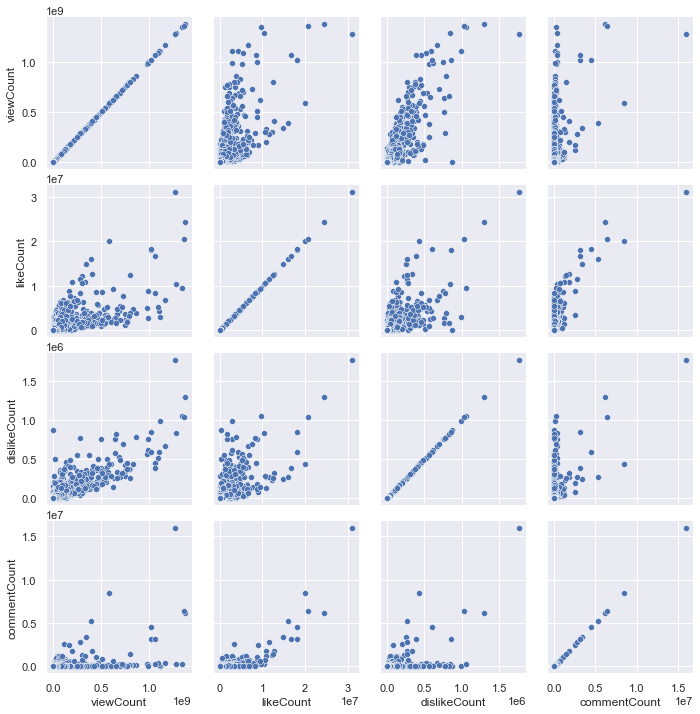

In [217]:
plt.figure(figsize=(30,30)) 
g=sns.PairGrid(df_eda)
g.map(sns.scatterplot)

<AxesSubplot:>

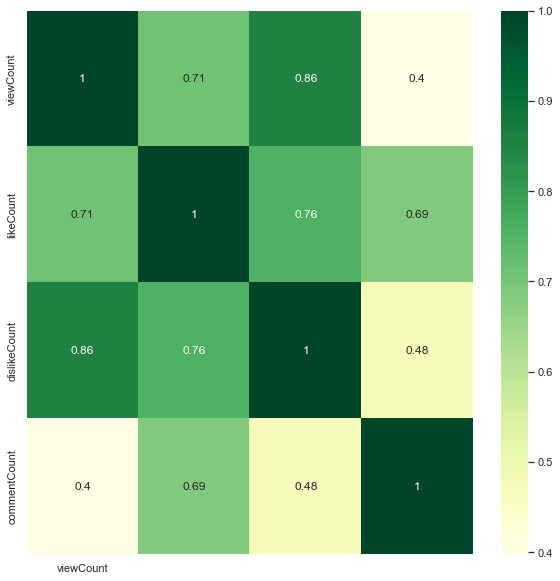

In [216]:
plt.figure(figsize=(15,29)) 
sns.heatmap(df_eda.corr(), annot=True,cmap = 'YlGn')

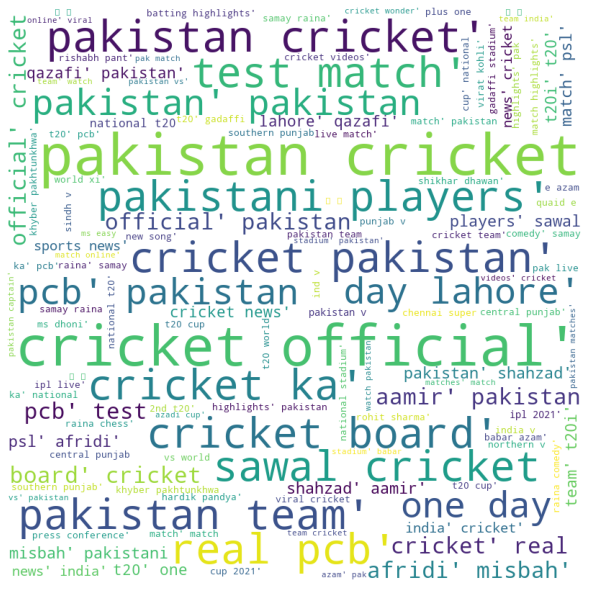

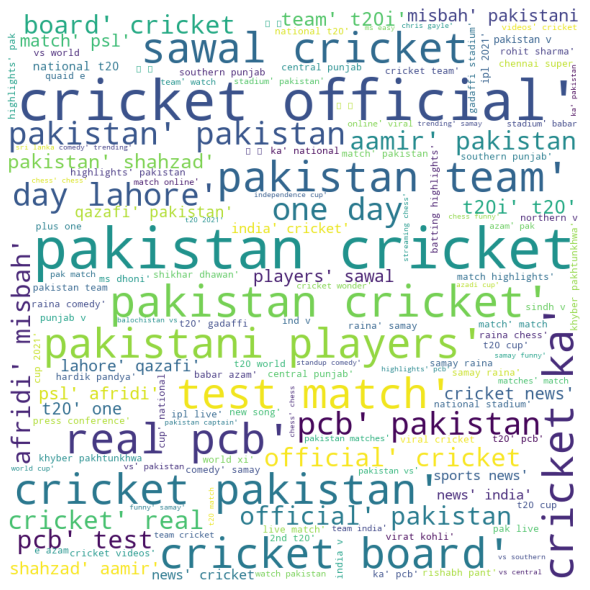

In [40]:
# word count
i = 0
for i in range(2):
    if i == 0:
        df_eda.sort_values(['likeCount'], ascending=False,axis=0,inplace=True)
    else:
        df_eda.sort_values(['dislikeCount'], ascending=False,axis=0,inplace=True)
    
    comment_words = ''
    stopwords = set(STOPWORDS)
    
    # iterate through the csv file
    for val in df.tags.iloc[0:10000]:
         
        # typecaste each val to string
        val = str(val)
     
        # split the value
        tokens = val.split()
        
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
         
        comment_words += " ".join(tokens)+" "
     
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)
     
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

plt.show()

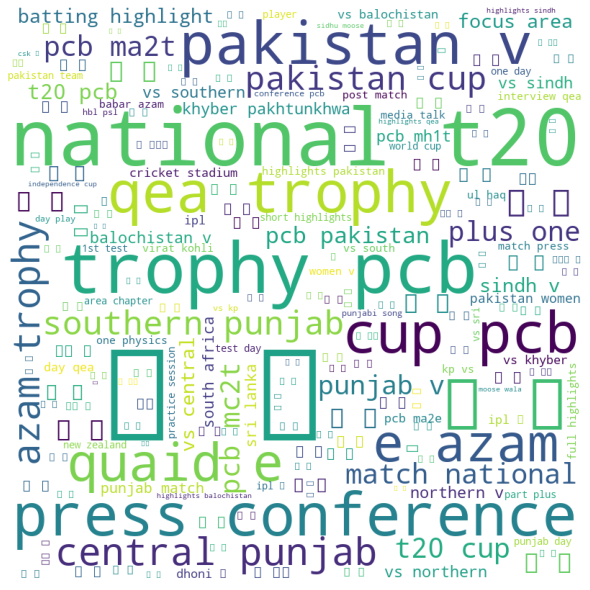

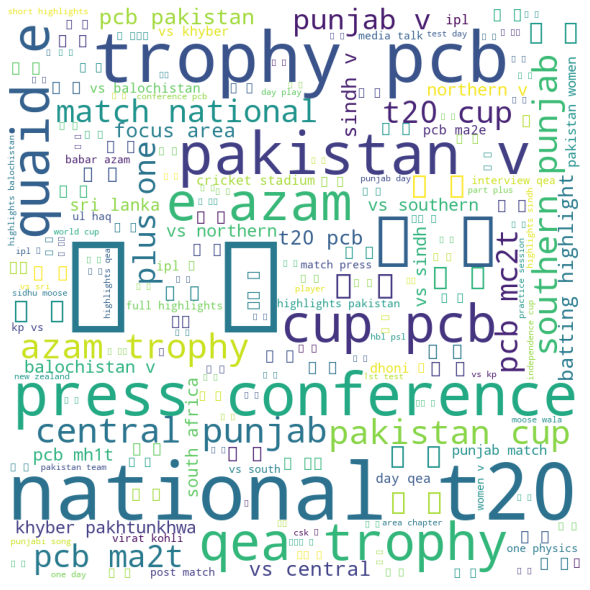

In [41]:
# word count
i = 0
for i in range(2):
    if i == 0:
        df_eda.sort_values(['likeCount'], ascending=False,axis=0,inplace=True)
    else:
        df_eda.sort_values(['dislikeCount'], ascending=False,axis=0,inplace=True)
    
    comment_words = ''
    stopwords = set(STOPWORDS)
    
    # iterate through the csv file
    for val in df.title.iloc[0:10000]:
         
        # typecaste each val to string
        val = str(val)
     
        # split the value
        tokens = val.split()
        
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
         
        comment_words += " ".join(tokens)+" "
     
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)
     
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
     
plt.show()

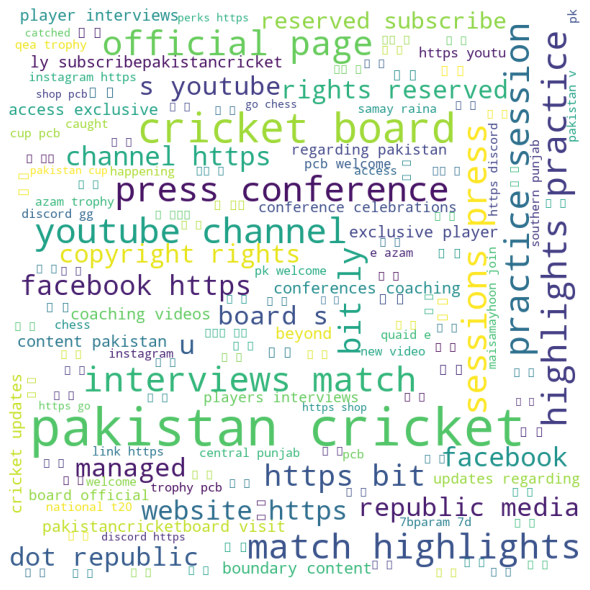

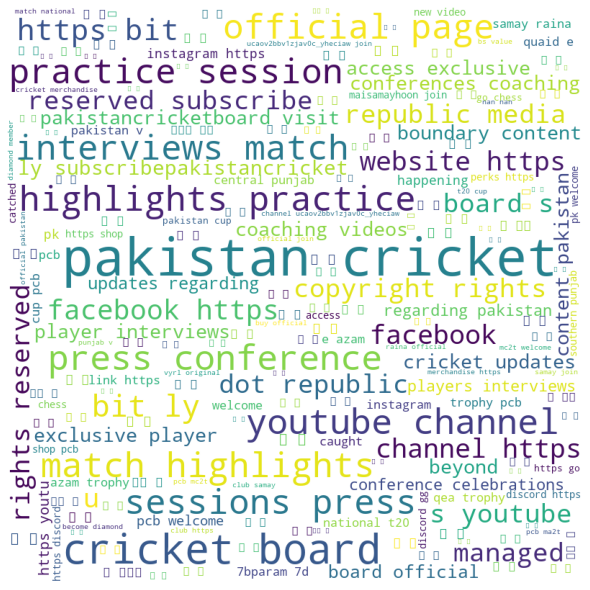

In [43]:
# word count
i = 0
for i in range(2):
    if i == 0:
        df_eda.sort_values(['likeCount'], ascending=False,axis=0,inplace=True)
    else:
        df_eda.sort_values(['dislikeCount'], ascending=False,axis=0,inplace=True)
    
    comment_words = ''
    stopwords = set(STOPWORDS)
    
    # iterate through the csv file
    for val in df.description.iloc[0:10000]:
         
        # typecaste each val to string
        val = str(val)
     
        # split the value
        tokens = val.split()
        
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
         
        comment_words += " ".join(tokens)+" "
     
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)
     
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
     
plt.show()

In [ ]:
# TODO: Tentative
#topic categories.
#topic modeling..
#datetime fromatting